In [1]:
!hostname
!pwd

31-34-11.wireless.csail.mit.edu
/Users/akarshkumar0101/synthetic-mdps/src


In [2]:
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import os
from tqdm.auto import tqdm
import glob
import matplotlib

from einops import rearrange, repeat

In [4]:

def plot_curve_lines(x, y, c="r", **kwargs):  # x.shape=(t, ), y.shape = (n, t)
    c = matplotlib.colors.to_rgba(c)
    plt.plot(x, y.mean(axis=0), c=c, **kwargs)
    c = [c[0], c[1], c[2], .1]
    plt.plot(x, y.T, c=c)

def plot_curve_err(x, y, c="r", **kwargs):  # x.shape=(t, ), y.shape = (n, t)
    c = matplotlib.colors.to_rgba(c)
    mean, std = y.mean(axis=0), y.std(axis=0)
    err = std/np.sqrt(y.shape[0])
    plt.plot(x, mean, c=c, **kwargs)
    c = [c[0], c[1], c[2], .1]
    plt.fill_between(x, mean-err, mean+err, color=c)


In [5]:

def viz_training(load_dir):
    print(load_dir)
    with open(f"{load_dir}/config.json", "r") as f:
        config = json.load(f)
    with open(f"{load_dir}/rew.pkl", "rb") as f:
        rew = np.asarray(pickle.load(f)) # (s, n, t)
    rew = rew.mean(axis=(-1))

    plt.figure(figsize=(10, 5))
    # plot_curve_err(np.arange(rew.shape[-1]), rew, c="r")
    plot_curve_lines(np.arange(rew.shape[-1]), rew, c="r")
    # smoothed = np.convolve(rew.mean(axis=0), np.ones(50)/50, mode='same')
    # plt.plot(smoothed, c='blue')

    plt.title(f"Pretraining Env:\n{config['env_id']}")
    plt.ylabel('Average Reward per Timestep')
    plt.xlabel('Training Steps')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'{args.save_dir}/plot_pretrain.png')
    # plt.close()


def viz_eval(load_dir):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    print(load_dir)
    eval_dirs = sorted([path for path in glob.glob(f"{load_dir}/*") if os.path.isdir(path)])
    assert len(eval_dirs) > 0
    plt.figure(figsize=(10, 5))
    for i, eval_dir in enumerate(eval_dirs):
        with open(f"{eval_dir}/config.json", "r") as f:
            config = json.load(f)
        env = config['env_id']
        if config['load_dir'] is not None:
            with open(f"{config['load_dir']}/config.json", "r") as f:
                config_pre = json.load(f)
            env_pre = config_pre['env_id']
        else:
            env_pre = "None"

        with open(f'{eval_dir}/rew.pkl', 'rb') as f:
            rew = np.asarray(pickle.load(f)) # (s, n, t)
        rew = rew.mean(axis=1)
        plot_curve_err(np.arange(rew.shape[-1]), rew, c=matplotlib.colors.to_rgba(colors[i]), label=f"pretrained on {env_pre}")
    plt.title(f'Evaluation Env:\n{env}')
    plt.ylabel('Per-Timestep Reward')
    plt.xlabel('In-Context Timesteps')
    plt.legend(loc=(0., 1.2))
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'{args.save_dir}/plot_eval.png')

def viz_eval_rollout(load_dir):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    print(load_dir)
    eval_dirs = sorted([path for path in glob.glob(f"{load_dir}/*") if os.path.isdir(path)])
    assert len(eval_dirs) > 0
    for i, eval_dir in enumerate(eval_dirs):
        with open(f"{eval_dir}/config.json", "r") as f:
            config = json.load(f)
        env = config['env_id']
        if config['load_dir'] is not None:
            with open(f"{config['load_dir']}/config.json", "r") as f:
                config_pre = json.load(f)
            env_pre = config_pre['env_id']
        else:
            env_pre = "None"

        with open(f"{eval_dir}/buffer.pkl", "rb") as f:
            buffer = jax.tree_map(lambda x: np.asarray(x), pickle.load(f))
        # print(jax.tree_map(lambda x: x.shape, buffer))
        
        env_state = buffer['info']['base_env_state']
        rew = buffer['rew']
        env_cfg = dict([sub.split('=') for sub in env.split(';')])
        from mdps.natural_mdps import CartPole, MountainCar, Acrobot
        e = dict(cartpole=CartPole(), mountaincar=MountainCar(), acrobot=Acrobot())[env_cfg['name']]
        print(env_cfg['name'])
        print(e)
        env_params = e.default_params
        from gymnax.visualize import Visualizer
        for seed in range(2):
            state_seq = [jax.tree_map(lambda x: x[seed, t, 0], env_state) for t in range(128)]
            cum_rewards = rew[seed, :, 0].tolist()
            cum_rewards = [0 for _ in state_seq]
            vis = Visualizer(e, env_params, state_seq, cum_rewards)
            vis.animate(f"{config['save_dir']}/anim_{seed}.gif")

../data/exp_transfer/eval/name=acrobot;fobs=T;rpo=16;mrl=4x32
acrobot
acrobot
acrobot


AttributeError: ObjCInstance b'NSConcreteNotification' has no attribute b'initWithFormat_shareContext_'

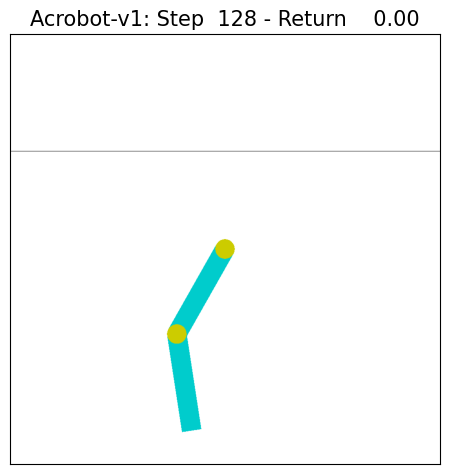

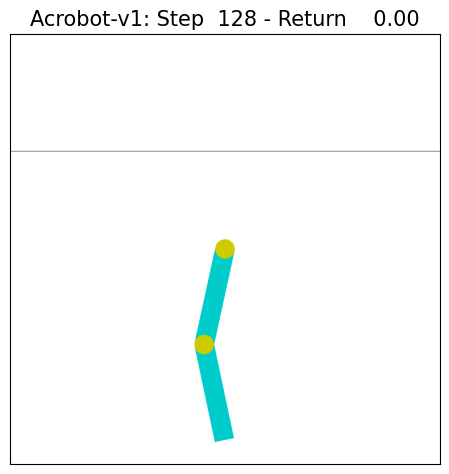

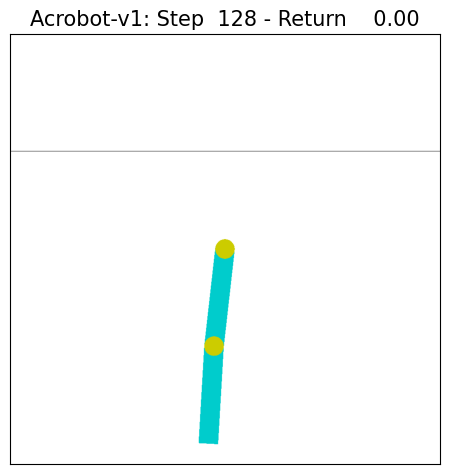

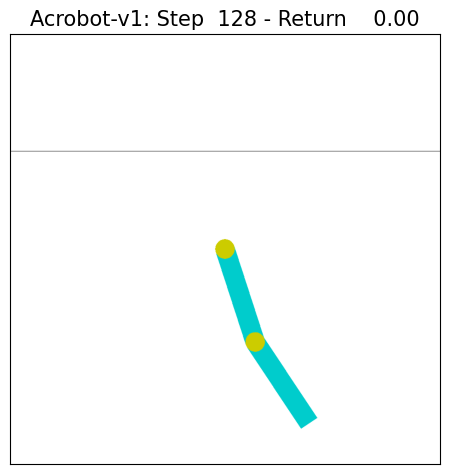

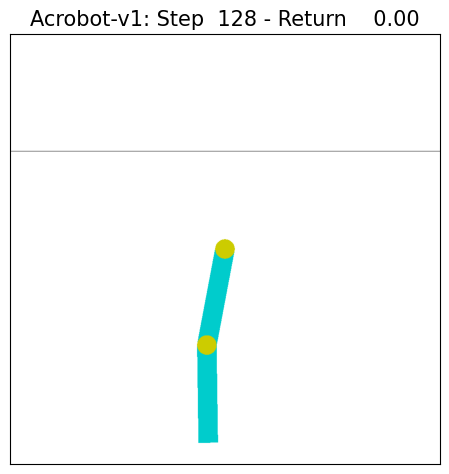

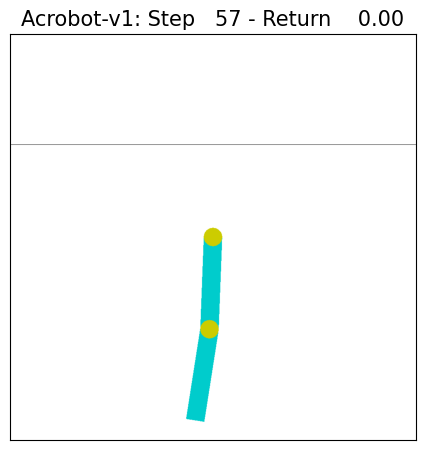

In [6]:
viz_eval_rollout("../data/exp_transfer/eval/name=acrobot;fobs=T;rpo=16;mrl=4x32")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/transfer/train/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32


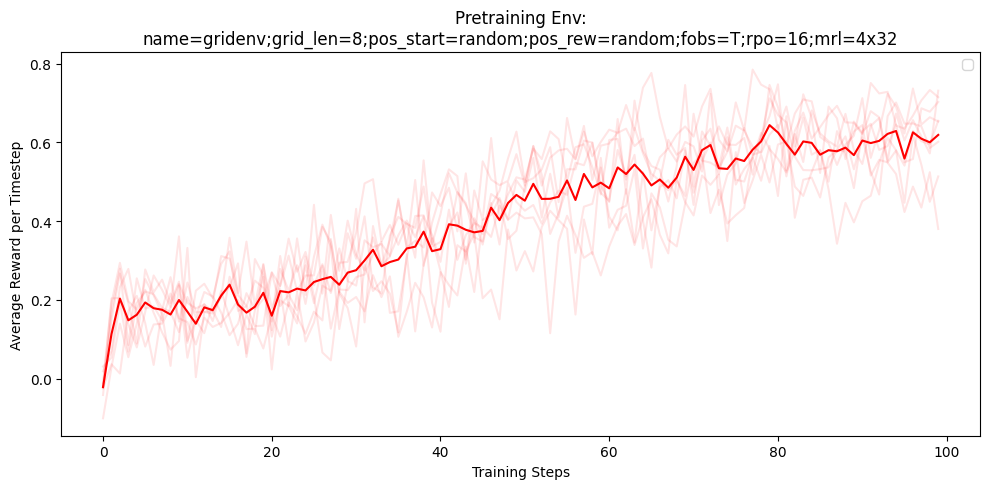

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/transfer/train/name=cartpole;fobs=T;rpo=16;mrl=4x32


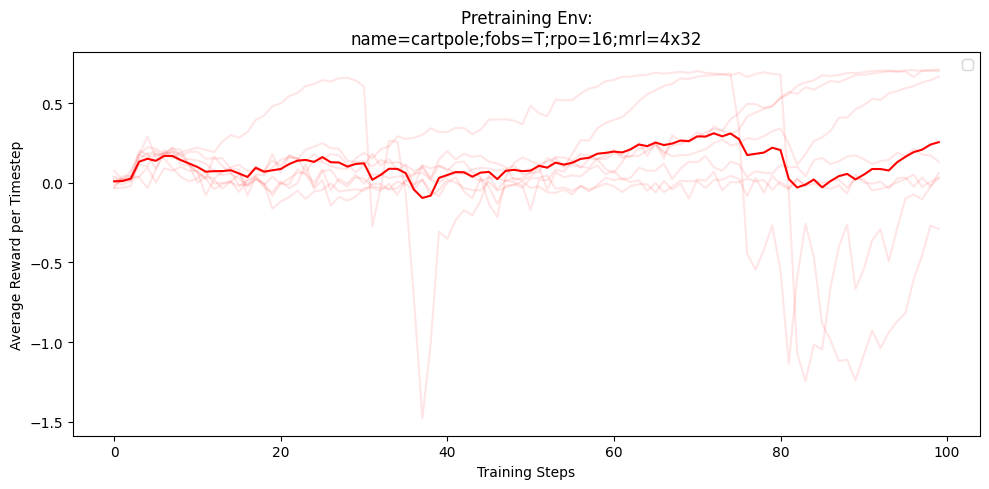

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/transfer/train/name=mountaincar;fobs=T;rpo=16;mrl=4x32


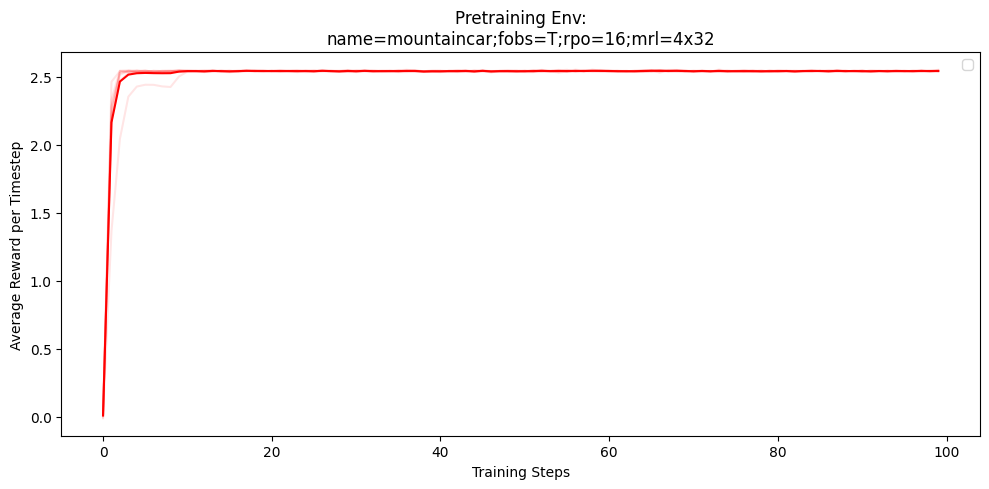

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/transfer/train/name=acrobot;fobs=T;rpo=16;mrl=4x32


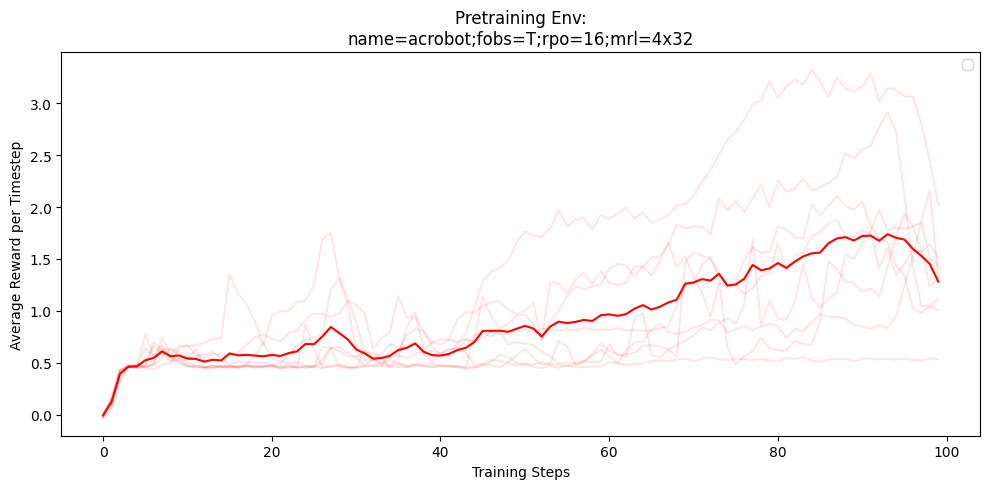

In [68]:
viz_training("../data/transfer/train/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32")
viz_training("../data/transfer/train/name=cartpole;fobs=T;rpo=16;mrl=4x32")
viz_training("../data/transfer/train/name=mountaincar;fobs=T;rpo=16;mrl=4x32")
viz_training("../data/transfer/train/name=acrobot;fobs=T;rpo=16;mrl=4x32")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=1x128


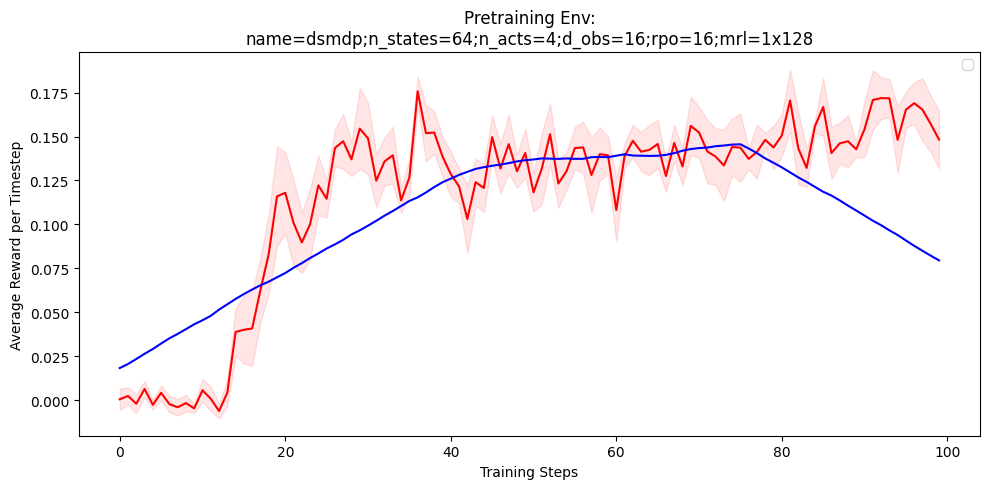

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=8x16


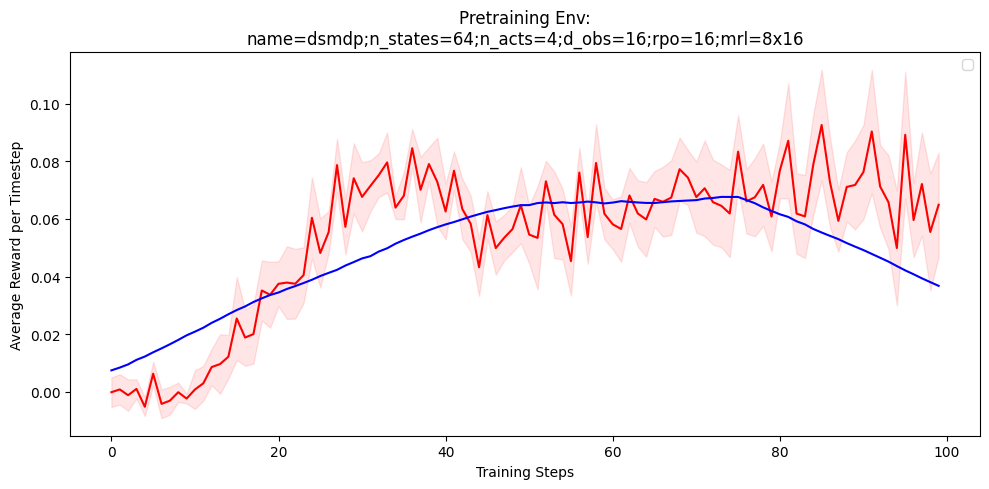

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=16x8


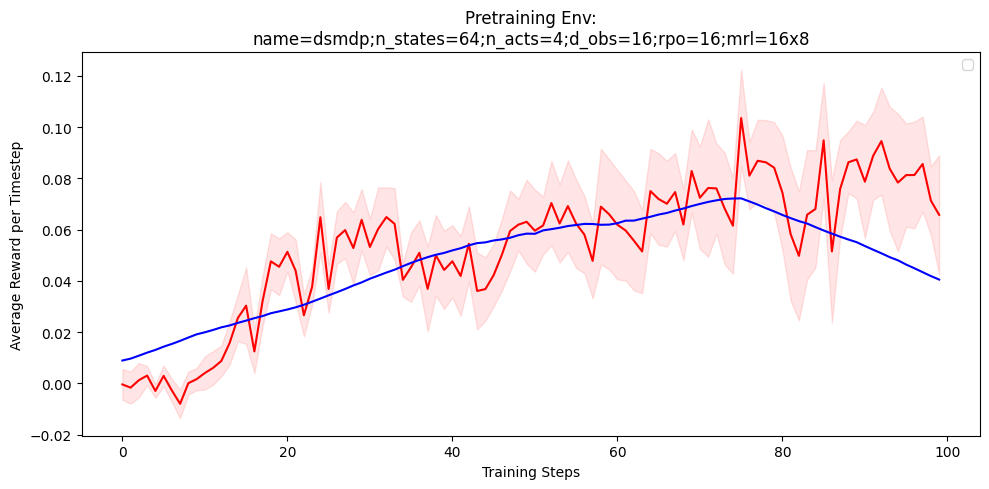

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1


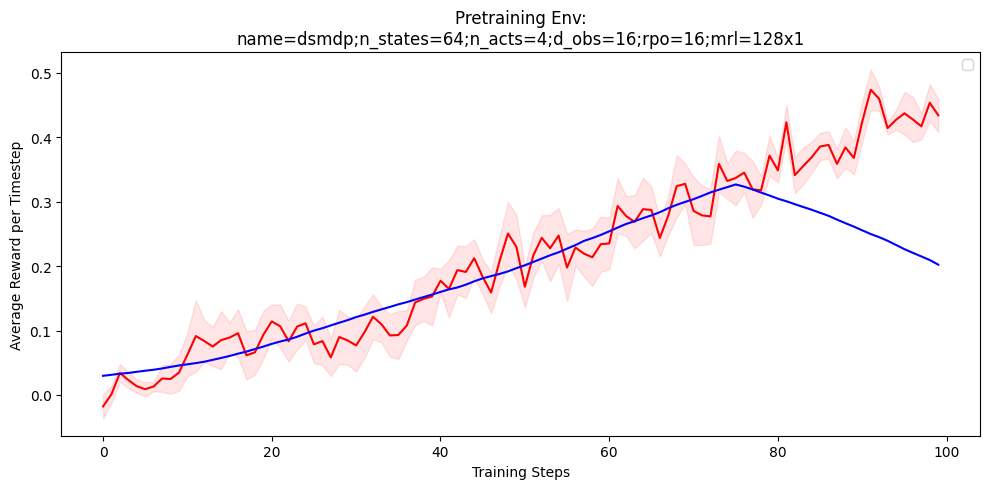

In [27]:

viz_training("../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=1x128")
viz_training("../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=8x16")
viz_training("../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=16x8")
viz_training("../data/train/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1")



../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=1x128
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)


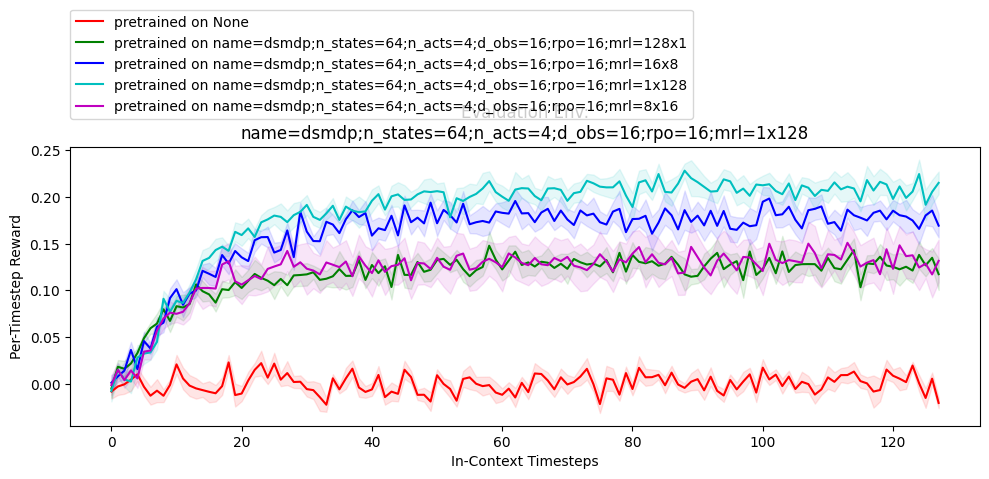

../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=8x16
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)


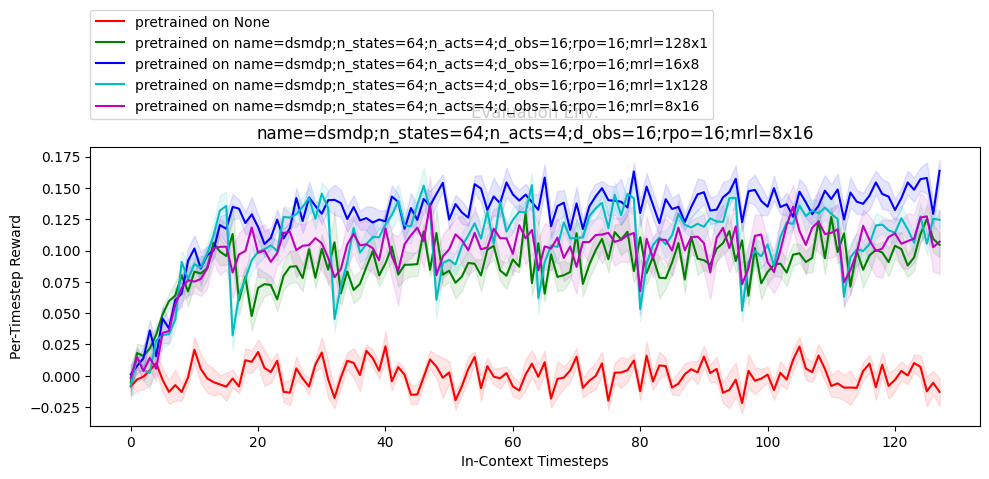

../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=16x8
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)


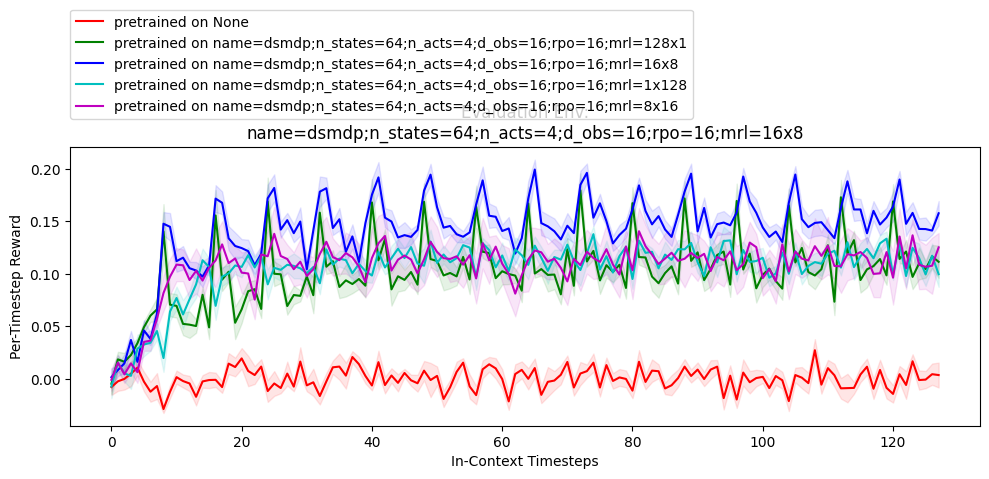

../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)
rewshape (8, 10, 128)


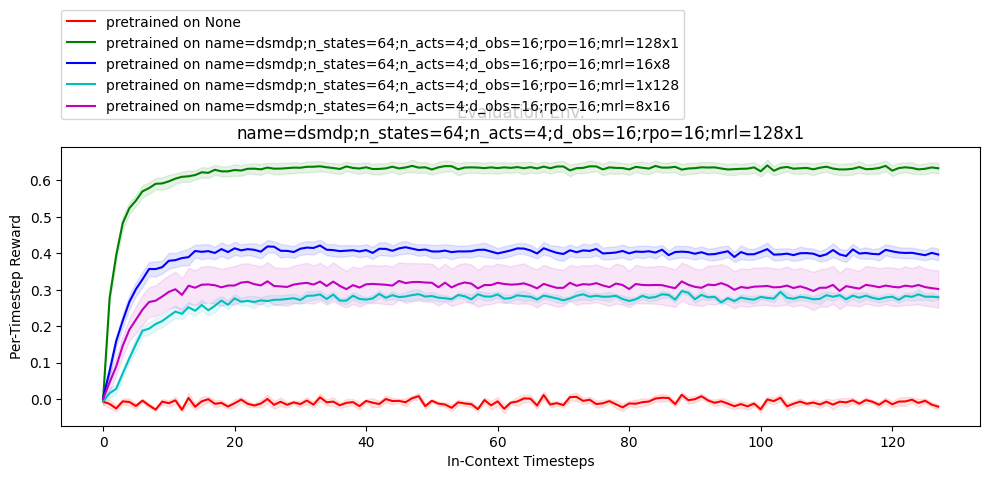

In [15]:

viz_eval("../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=1x128")
viz_eval("../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=8x16")
viz_eval("../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=16x8")
viz_eval("../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1")



../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1


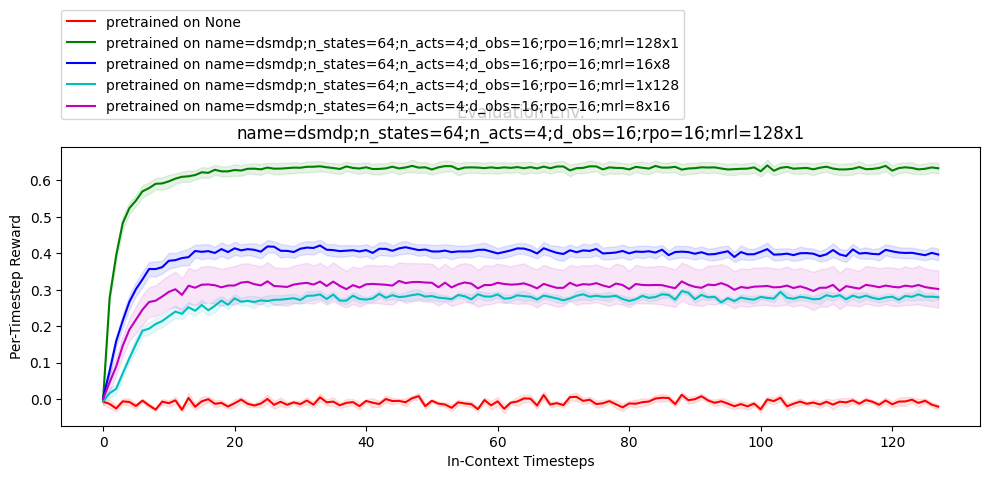

../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=8x16
{'act': (8, 128, 128), 'done': (8, 128, 128), 'env_state': {'_state': (8, 128, 128), 'time': (8, 128, 128)}, 'info': {'done_trial': (8, 128, 128)}, 'log_prob': (8, 128, 128), 'logits': (8, 128, 128, 4), 'obs': {'act_p': (8, 128, 128), 'done': (8, 128, 128), 'obs': (8, 128, 128, 16), 'rew_p': (8, 128, 128)}, 'rew': (8, 128, 128), 'val': (8, 128, 128)}


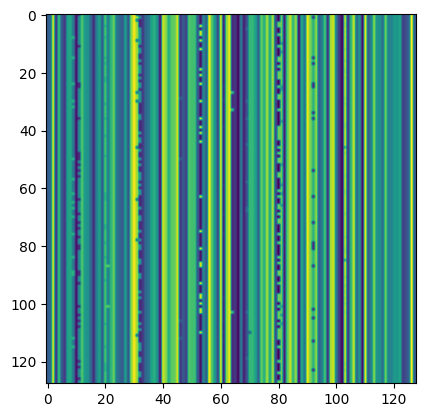

In [86]:
viz_eval("../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1")

../data/transfer/eval/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32


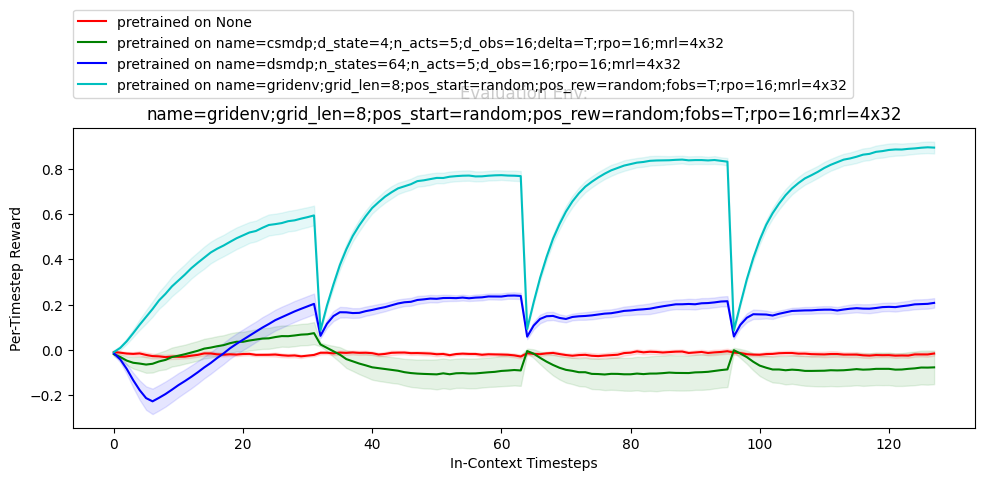

../data/transfer/eval/name=cartpole;fobs=T;rpo=16;mrl=4x32


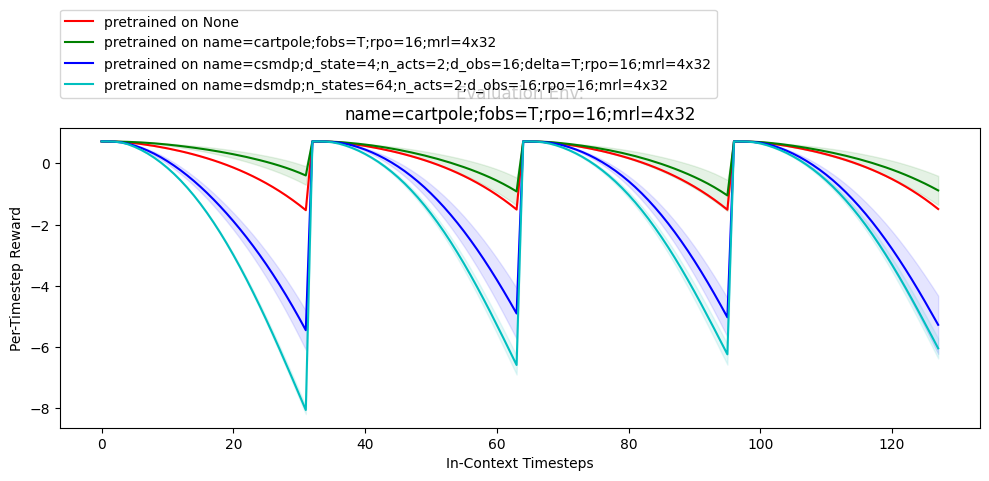

../data/transfer/eval/name=mountaincar;fobs=T;rpo=16;mrl=4x32


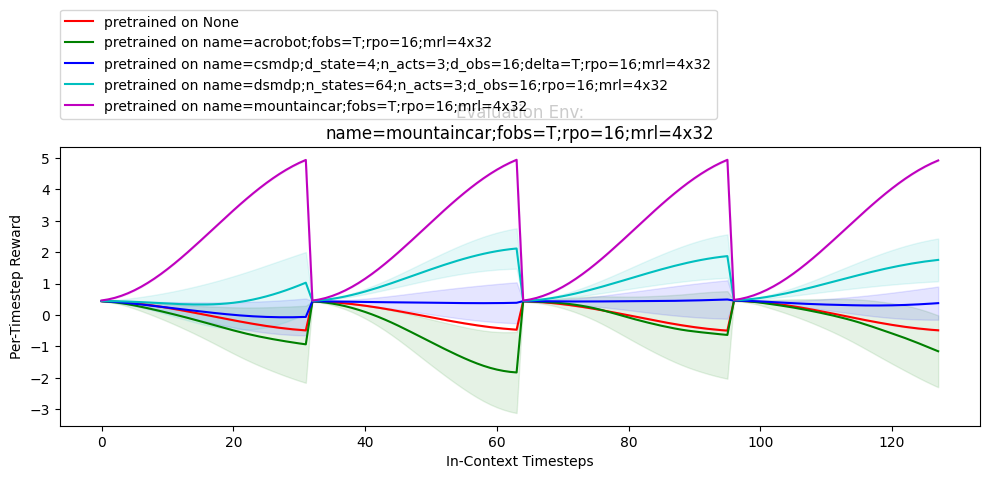

../data/transfer/eval/name=acrobot;fobs=T;rpo=16;mrl=4x32


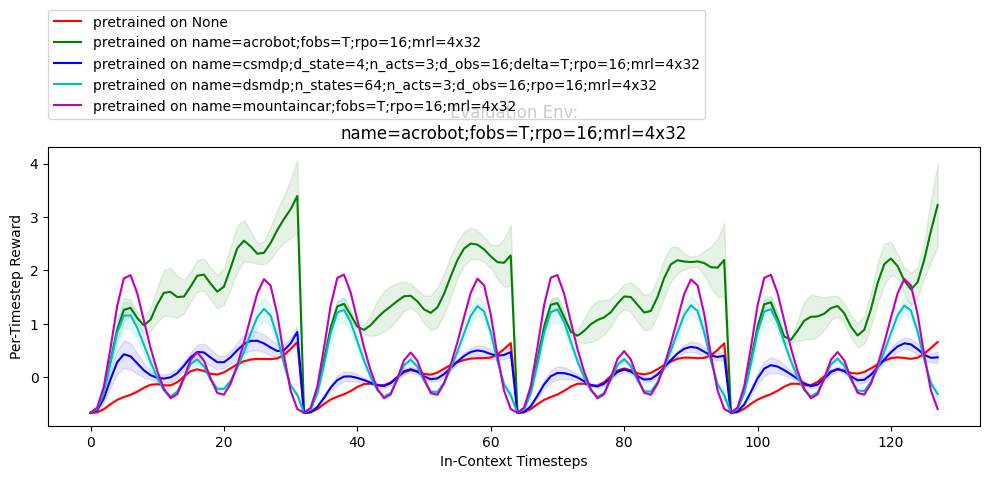

../data/transfer/eval/name=dsmdp;n_states=64;n_acts=5;d_obs=16;rpo=16;mrl=4x32


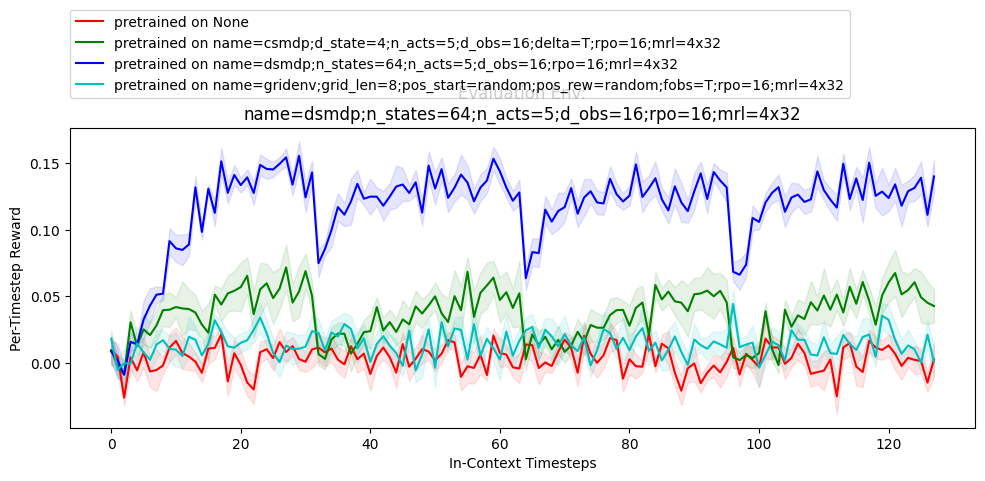

In [90]:
viz_eval("../data/transfer/eval/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32")
viz_eval("../data/transfer/eval/name=cartpole;fobs=T;rpo=16;mrl=4x32")
viz_eval("../data/transfer/eval/name=mountaincar;fobs=T;rpo=16;mrl=4x32")
viz_eval("../data/transfer/eval/name=acrobot;fobs=T;rpo=16;mrl=4x32")

viz_eval("../data/transfer/eval/name=dsmdp;n_states=64;n_acts=5;d_obs=16;rpo=16;mrl=4x32")
# viz_eval("../data/transfer/eval/name=csmdp;d_state=4;n_acts=5;d_obs=16;delta=T;rpo=16;mrl=4x32")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


../data/transfer/train/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32


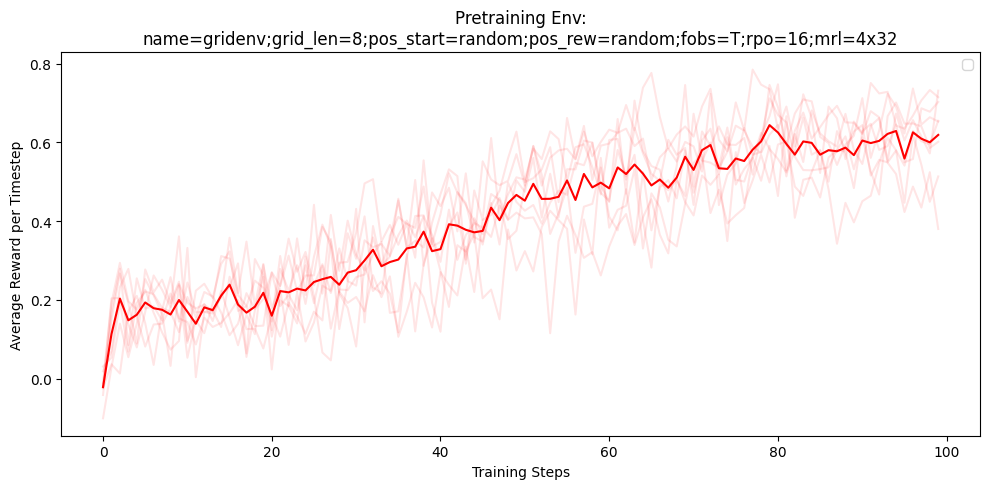

In [91]:
viz_training("../data/transfer/train/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32")

../data/mrl_horizon/eval/name=dsmdp;n_states=64;n_acts=4;d_obs=16;rpo=16;mrl=128x1


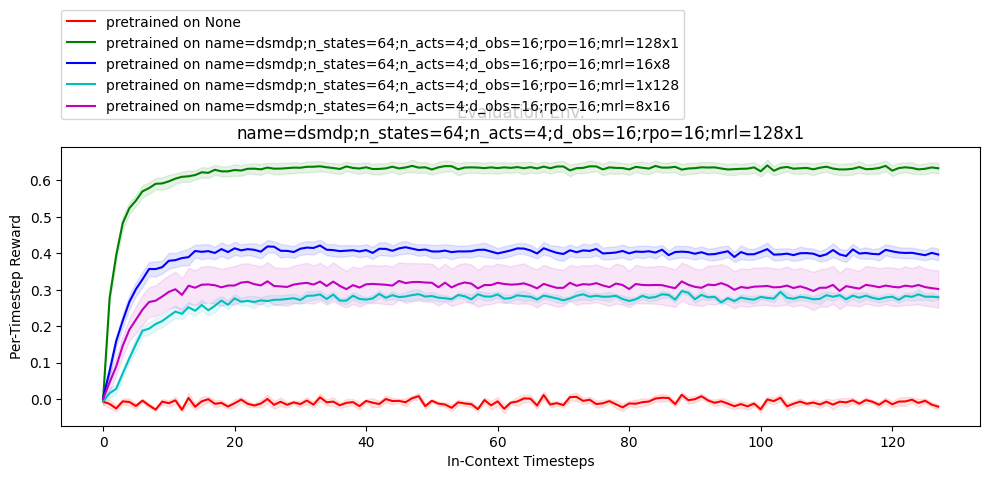

{'act': (8, 128, 128), 'done': (8, 128, 128), 'env_state': {'_state': (8, 128, 128), 'time': (8, 128, 128)}, 'info': {'done_trial': (8, 128, 128)}, 'log_prob': (8, 128, 128), 'logits': (8, 128, 128, 4), 'obs': {'act_p': (8, 128, 128), 'done': (8, 128, 128), 'obs': (8, 128, 128, 16), 'rew_p': (8, 128, 128)}, 'rew': (8, 128, 128), 'val': (8, 128, 128)}


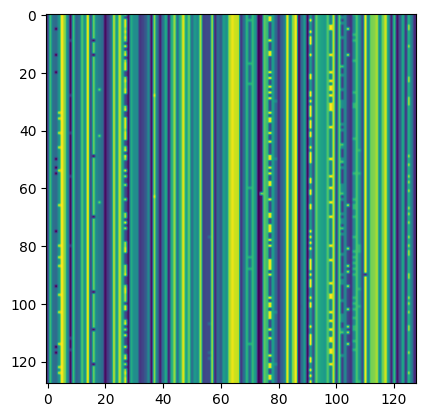

../data/train/name=dsmdp;n_states=64;n_acts=5;d_obs=16;rpo=16;mrl=4x32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


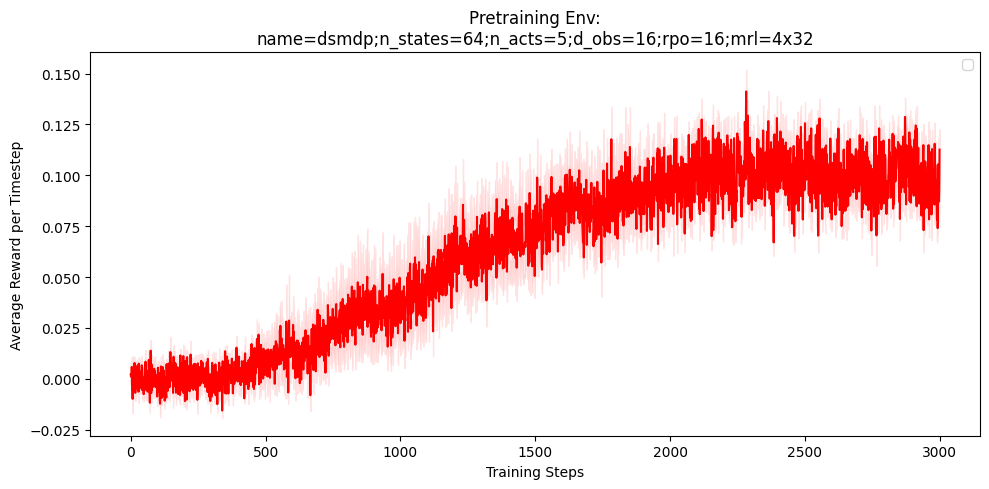

In [56]:
viz_training("../data/train/name=dsmdp;n_states=64;n_acts=5;d_obs=16;rpo=16;mrl=4x32")

In [87]:
viz_eval("../data/eval/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32")
viz_eval("../data/eval/name=cartpole;fobs=T;rpo=16;mrl=4x32")
viz_eval("../data/eval/name=mountaincar;fobs=T;rpo=16;mrl=4x32")
viz_eval("../data/eval/name=acrobot;fobs=T;rpo=16;mrl=4x32")

../data/eval/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32


AssertionError: 

../data/eval/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;rpo=16;mrl=4x32


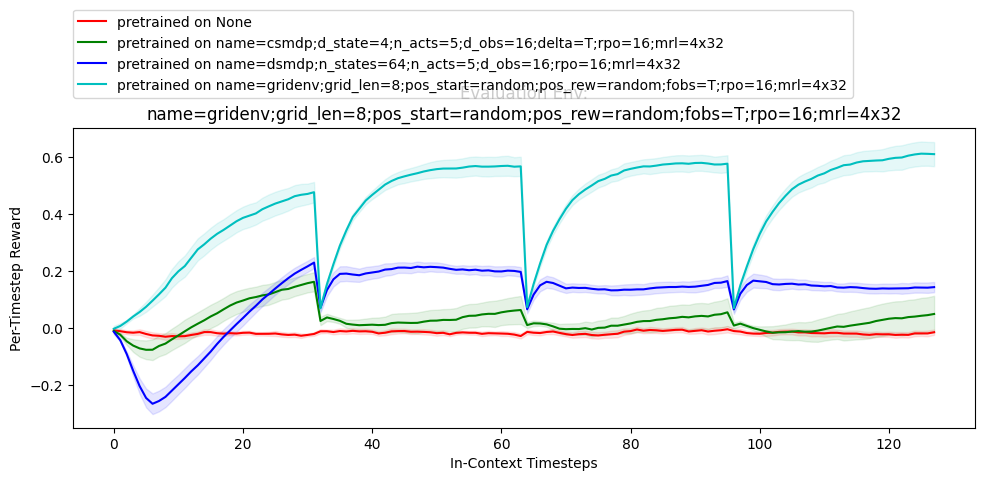

In [10]:
!ls "../data/transfer/name=gridenv;grid_len=8;fobs=T;rpo=64;tl=128/name=gridenv;grid_len=8;fobs=T;rpo=64;tl=128"

buffers.pkl  config.json  rew.pkl


In [96]:
with open("../data/transfer/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128/buffers.pkl", "rb") as f:
    buffers = jax.tree_map(lambda x: jnp.asarray(x), pickle.load(f))

In [97]:
buffers[0].keys()

dict_keys(['act', 'done', 'env_state', 'info', 'log_prob', 'logits', 'obs', 'rew', 'val'])

In [90]:
d = np.stack([b['info']['goal_dist'] for b in buffers], axis=1)
d.shape

(8, 10, 128, 128)

(0.0, 9.0)

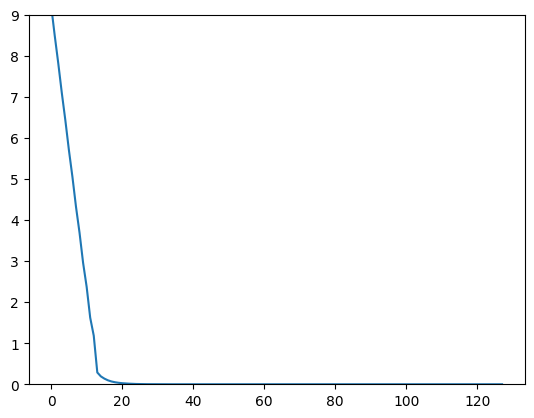

In [93]:
plt.plot(d.mean(axis=(0, 1, 3)))
plt.ylim(0, 9)